In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.lib import *
print(tf.__version__)

d:\ads_test
2.13.0


In [2]:
print(tf.__version__)

2.13.0


In [3]:
data_order = 8

In [4]:
exps_dir = "../../../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/feature1"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [5]:
dict_data=[]
y_list = []
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    
    # Khởi tạo một trình chuyển đổi OneHotEncoder
    encoder = OneHotEncoder()
    
    # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
    labels_reshaped = labels.reshape(-1, 1)
    
    # Fit trình chuyển đổi vào dữ liệu
    encoder.fit(labels_reshaped)
    
    # Chuyển đổi labels sang dạng one-hot encoding
    onehot_labels = encoder.transform(labels_reshaped)
    return onehot_labels
for scaler in ['Standard_Label','MinMax_Label']:
    for type in ['basic','class_dict_weight','Oversampling','SMOTE','Undersampling']:
        x_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_train.xlsx')
        y_train = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_train.xlsx')
        x_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/x_test.xlsx')
        y_test = pd.read_excel(f'{exps_dir}/{scaler}/{type}/feature/y_test.xlsx')
        y_list.append(y_test)
        y_train=oneHot(y_train)
        y_test=oneHot(y_test)
        print(f'{scaler}: {type}')
        print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
        dict_data.append((x_train,y_train,x_test,y_test))

class_weights_dict=dict(np.load(f'{exps_dir}/Standard_Label/class_dict_weight/feature/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict
print(len(dict_data))

FileNotFoundError: [Errno 2] No such file or directory: '../../../../exps/Standard_Label/basic/feature/x_train.xlsx'

In [ ]:
# x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
# y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
# x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
# y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
# class_weights_dict=dict(np.load(f'{exps_dir}/feature1/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
# class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
# class_weights_dict

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# import numpy as np

# # Dữ liệu label đã được mã hóa
# def oneHot(arr):
#     labels = np.array(arr)
#     # Khởi tạo một trình chuyển đổi OneHotEncoder
#     encoder = OneHotEncoder(sparse=False)
    
#     # Reshape lại dữ liệu labels để có dạng cột (cần là ma trận 2D)
#     labels_reshaped = labels.reshape(-1, 1)
    
#     # Fit trình chuyển đổi vào dữ liệu
#     encoder.fit(labels_reshaped)
    
#     # Chuyển đổi labels sang dạng one-hot encoding
#     onehot_labels = encoder.transform(labels_reshaped)
#     return onehot_labels

x_train = dict_data[data_order][0]
x_test = dict_data[data_order][2]
y_train = dict_data[data_order][1]  # Chuyển đổi nhãn huấn luyện thành mã one-hot
y_test = dict_data[data_order][3]   # Chuyển đổi nhãn kiểm tra thành mã one-hot


In [ ]:
print(y_train.shape)

(1002, 2)


In [ ]:
# y_train_onehot=oneHot(y_train)
# y_test_onehot=oneHot(y_test)

In [ ]:
# print(y_train_onehot.shape)

In [ ]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [8]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tabnet_keras.models import TabNetClassifier
# from tabnet_keras.utils.metrics import f1_score

# Định nghĩa tham số regularization
l2_reg = 0.01

learning_rate = 0.1
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax",  # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3,
    "virtual_batch_splits": 8  # number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}

from tabnet_keras.models import TabNetEncoder, TabNetClassifier

# Define the input shape

# Create input layer

# Create TabNetEncoder
# tabnet_encoder = TabNetEncoder(**tabnet_params)

# Connect input to the TabNetEncoder
# encoder_output = tabnet_encoder(input_tabnet)


### Classification
tabnet = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)

# Tạo biến cho mô hình
dummy_input = tf.zeros((1, 42))  # Thay thế input_shape bằng hình dạng của dữ liệu thực tế
tabnet(dummy_input)

# Tải trọng số từ tệp đã lưu
tabnet.load_weights('./tabnet_fraud2.h5')

# Compile mô hình
tabnet.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Định nghĩa các callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=70,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=30,
    min_lr=0.000001,
    verbose=1,
)
tabnet.summary()

Model: "tab_net_classifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder_2 (TabNetE  multiple                  27904     
 ncoder)                                                         
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 27936 (109.12 KB)
Trainable params: 25552 (99.81 KB)
Non-trainable params: 2384 (9.31 KB)
_________________________________________________________________


In [50]:
tabnet.inputs

In [51]:


input_shape = (42, 1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size = 3
filter_size = 128

# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size * 2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size * 2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size * 4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size * 4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size * 4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size * 8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size * 8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size * 8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size * 8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size * 8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size * 8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)
x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

# Tạo mô hình
vgg16 = Model(x_input, x, name='vgg16')

# Tạo biến cho mô hình
dummy_input = tf.zeros((1, input_shape[0], input_shape[1]))
vgg16(dummy_input)

# Tải trọng số từ tệp đã lưu
vgg16.load_weights('Vgg16/vgg16_fraud1.h5')

# Compile mô hình
vgg16.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy', f1_score])

# Định nghĩa các callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=15,
    min_lr=0.000001,
    verbose=1,
)

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 42, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 42, 128)           512       
                                                                 
 block1_conv2 (Conv1D)       (None, 42, 128)           49280     
                                                                 
 block1_pool (MaxPooling1D)  (None, 21, 128)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 21, 256)           98560     
                                                                 
 block2_conv2 (Conv1D)       (None, 21, 256)           196864    
                                                                 
 block2_pool (MaxPooling1D)  (None, 10, 256)           0     

In [52]:
tabnet_pred = tabnet.predict(dict_data[data_order][2])
predictions = np.argmax(tabnet_pred, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 2s 6ms/step


0.7962962962962963

In [53]:
vgg16_pred = vgg16.predict(dict_data[data_order][2])
predictions = np.argmax(vgg16_pred, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 1s 30ms/step


0.7901234567901234

In [55]:
tabnet.get_layer('tab_net_encoder_2')

In [59]:

def tabnet_feature(model,input_shape=(42), proba=False):
    input = Input(shape=input_shape)
    feature = tabnet.get_layer('tab_net_encoder_2')(input)
    probability=tabnet.get_layer('classifier')(feature)
    if proba:
        output=Concatenate()([feature,probability])
    else:
        output=feature
    model = Model(inputs=input,outputs=[output])
    return model
feat_model=tabnet_feature(tabnet)
# output=feat_model(dummy_input)
# print(output.shape)

In [17]:
from tensorflow.keras.optimizers import Adam
lr=0.0001
from keras.models import Sequential


def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=2048, step=32),
                           activation='relu', input_dim=42))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_4', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(units=hp.Int('units_5', min_value=32, max_value=2048, step=32),
                           activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
    return model

# keras_clf = KerasClassifier(build_fn=create_keras_model, epochs=10)



# keras_pred = keras_clf.predict(x_test)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

lr=0.0001
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
# Tạo đối tượng RandomSearch tuner
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=5)

# Tìm kiếm tham số tốt nhất
tuner.search(x_train, y_train, epochs=1200, validation_data=(x_test, y_test),callbacks=[early_stopping,lr_scheduler])

# Lấy mô hình tốt nhất
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Reloading Tuner from .\untitled_project\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               6880      
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 800)               128800    
                                                                 
 batch_normalization_1 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 dro

In [18]:
print(x_train.shape,y_train.shape)

(1002, 42) (1002, 2)


In [19]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin


# Step 1: Load pre-trained models for TabNet, VGG16, and MLP

# Assume you already have pre-trained models saved as tabnet_model, vgg16_model, and mlp_model
# earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 30)

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)

# Step 2: Early fusion to combine outputs of TabNet, VGG16, and MLP
MLP_pred=best_model.predict(x_test)


# keras_pred = keras_clf.predict(x_test)
stacked_input = np.column_stack((tabnet_pred,vgg16_pred,MLP_pred))

def early_fusion(tabnet_output, vgg16_output, mlp_output):
    # Perform early fusion here (e.g., concatenate outputs)
    fused_output = np.concatenate((tabnet_output, vgg16_output, mlp_output), axis=1)
    return fused_output

# Step 3: Create a simple classifier

def create_simple_classifier(input_dim):
    # Define a simple classifier model
    model = Sequential([
        
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
    return model

# Step 4: Implement Early Fusion Classifier

class EarlyFusionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, tabnet_model, vgg16_model, mlp_model):
        self.tabnet_model = tabnet_model
        self.vgg16_model = vgg16_model
        self.mlp_model = mlp_model
        self.classifier = None
        self.history = None

    def fit(self, X, y):
        # No training is needed for pre-trained models
        
        # Perform predictions using pre-trained models
        tabnet_output = self.tabnet_model.predict(X)
        vgg16_output = self.vgg16_model.predict(X)
        mlp_output = self.mlp_model.predict(X)

        tabnet_output_test = self.tabnet_model.predict(x_test)
        vgg16_output_test = self.vgg16_model.predict(x_test)
        mlp_output_test = self.mlp_model.predict(x_test)
        
        # Perform early fusion
        fused_output = early_fusion(tabnet_output, vgg16_output, mlp_output)
        fused_test_output = early_fusion(tabnet_output_test, vgg16_output_test, mlp_output_test)

        # Create and train a simple classifier
        input_dim = fused_output.shape[1]
        self.classifier = create_simple_classifier(input_dim)
        self.history =self.classifier.fit(x=fused_output,y=y,validation_data=(fused_test_output,y_test.toarray()),
          batch_size=64,epochs= 1200, callbacks=[early_stopping,lr_scheduler])

    def predict(self, X):
        # Perform predictions using early fusion classifier
        
        # Perform predictions using pre-trained models
        tabnet_output = self.tabnet_model.predict(X)
        vgg16_output = self.vgg16_model.predict(X)
        mlp_output = self.mlp_model.predict(X)
        
        # Perform early fusion
        fused_output = early_fusion(tabnet_output, vgg16_output, mlp_output)
        
        return self.classifier.predict(fused_output)

# Example usage:

# Create an instance of the Early Fusion Classifier
earlyfusion_classifier = EarlyFusionClassifier(tabnet_model=tabnet, vgg16_model=vgg16, mlp_model=best_model)

# Train the Early Fusion Classifier
earlyfusion_classifier.fit(x_train, y_train.toarray())

# Predict using the trained Early Fusion Classifier
predictions = earlyfusion_classifier.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy


11/11 [==============================] - 0s 3ms/step
Epoch 1/1200
16/16 [==============================] - 1s 15ms/step - loss: 0.5155 - accuracy: 0.7864 - f1_score: 0.7895 - val_loss: 0.5659 - val_accuracy: 0.7901 - val_f1_score: 0.8229 - lr: 0.0100
Epoch 2/1200
16/16 [==============================] - 0s 3ms/step - loss: 0.4770 - accuracy: 0.8014 - f1_score: 0.8026 - val_loss: 0.5816 - val_accuracy: 0.7870 - val_f1_score: 0.8203 - lr: 0.0100
Epoch 3/1200
16/16 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.8124 - f1_score: 0.8144 - val_loss: 0.5444 - val_accuracy: 0.7901 - val_f1_score: 0.8229 - lr: 0.0100
Epoch 4/1200
16/16 [==============================] - 0s 3ms/step - loss: 0.4769 - accuracy: 0.8124 - f1_score: 0.8118 - val_loss: 0.5240 - val_accuracy: 0.7870 - val_f1_score: 0.8203 - lr: 0.0100
Epoch 5/1200
16/16 [==============================] - 0s 3ms/step - loss: 0.4741 - accuracy: 0.8124 - f1_score: 0.8113 - val_loss: 0.5738 - val_accuracy: 0.78

0.7932098765432098

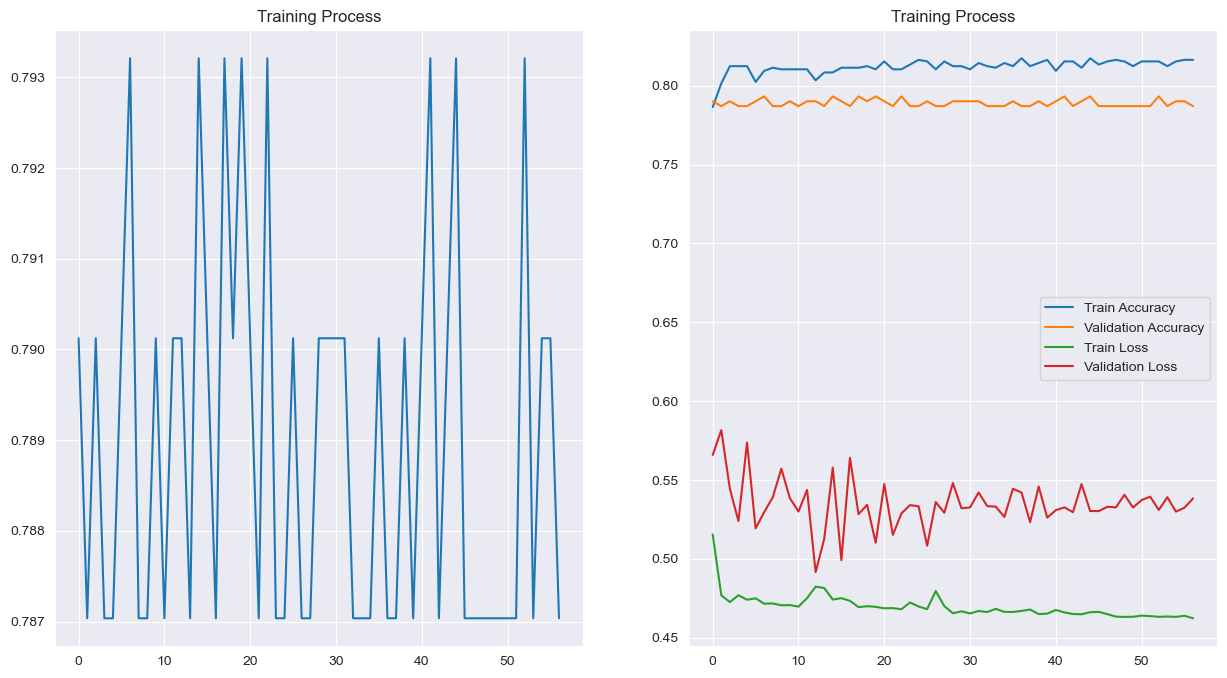

<Figure size 640x480 with 0 Axes>

In [20]:
history=earlyfusion_classifier.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')

axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].legend()

plt.show()
plt.savefig('train.png')

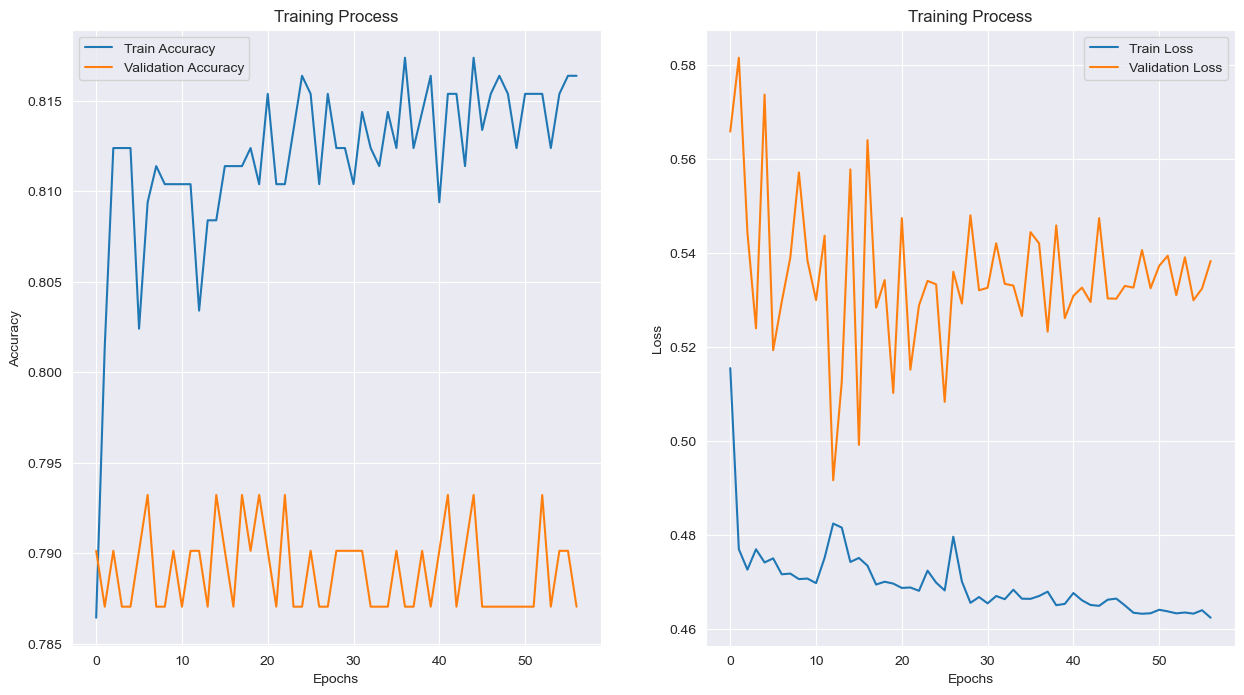

<Figure size 640x480 with 0 Axes>

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_list[data_order], predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_list[data_order], predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.7932098765432098
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.71      0.64        85
           0       0.89      0.82      0.85       239

    accuracy                           0.79       324
   macro avg       0.74      0.77      0.75       324
weighted avg       0.81      0.79      0.80       324



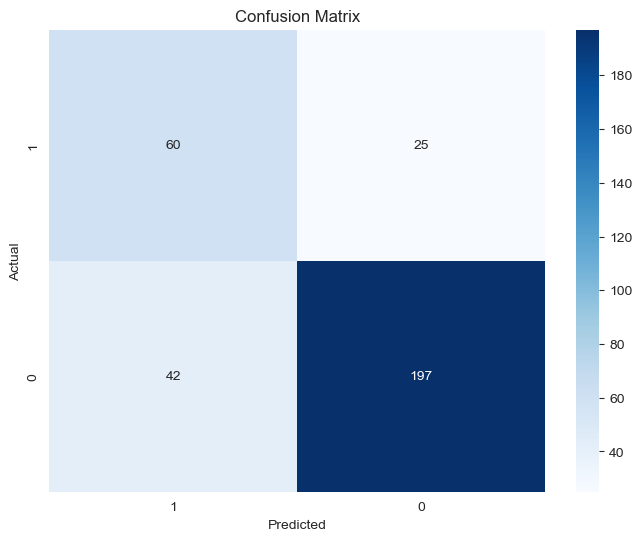

In [23]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_list[data_order], predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

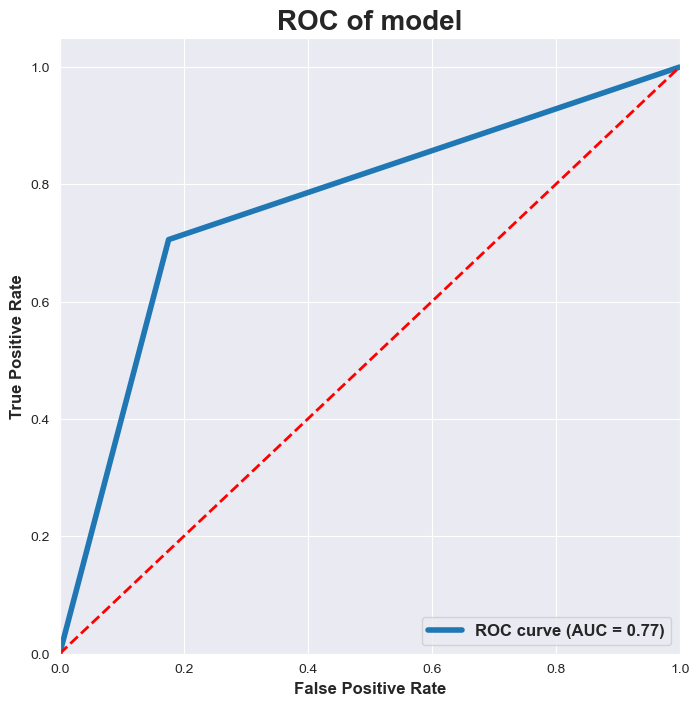

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_list[data_order],predictions,axes)
# predictions

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate
import numpy as np
from tensorflow.keras.layers import Input



# Sử dụng lớp đầu vào để tạo một mô hình tabnet với đầu vào được định nghĩa
# Ví dụ:
# tabnet_model = Model(inputs=input_tabnet, outputs=output_tabnet)


# Load VGG16 model
base_model_vgg16 = vgg16
base_mlp_model=best_model
# base_model_tabnet = Model(input=input_tabnet,output=tabnet.output)

# Freeze convolutional layers
for layer in base_model_vgg16.layers:
    layer.trainable = False
for layer in base_mlp_model.layers:
    layer.trainable = False

# # Define a new model for VGG16 with global average pooling
# x_vgg16 = base_model_vgg16.output
# x_vgg16 = GlobalAveragePooling2D()(x_vgg16)
# model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=x_vgg16)

# Load your other model and do necessary preprocessing
# Assuming you have another model named model_tabnet

# Concatenate outputs from both models
combined_output = Concatenate()([base_model_vgg16.output, base_mlp_model.output])

# Add additional layers as needed

x = Flatten(name='flatten')(combined_output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# x=GlobalAveragePooling1D()(combined_output)
# predictions = Dense(2, activation='softmax')(x)
# Create the final model
final_model = Model(inputs=[base_model_vgg16.input, base_mlp_model.input], outputs=predictions)

# Compile the model
final_model.compile(optimizer=tf.keras.optimizers.Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=50,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
# Train the model



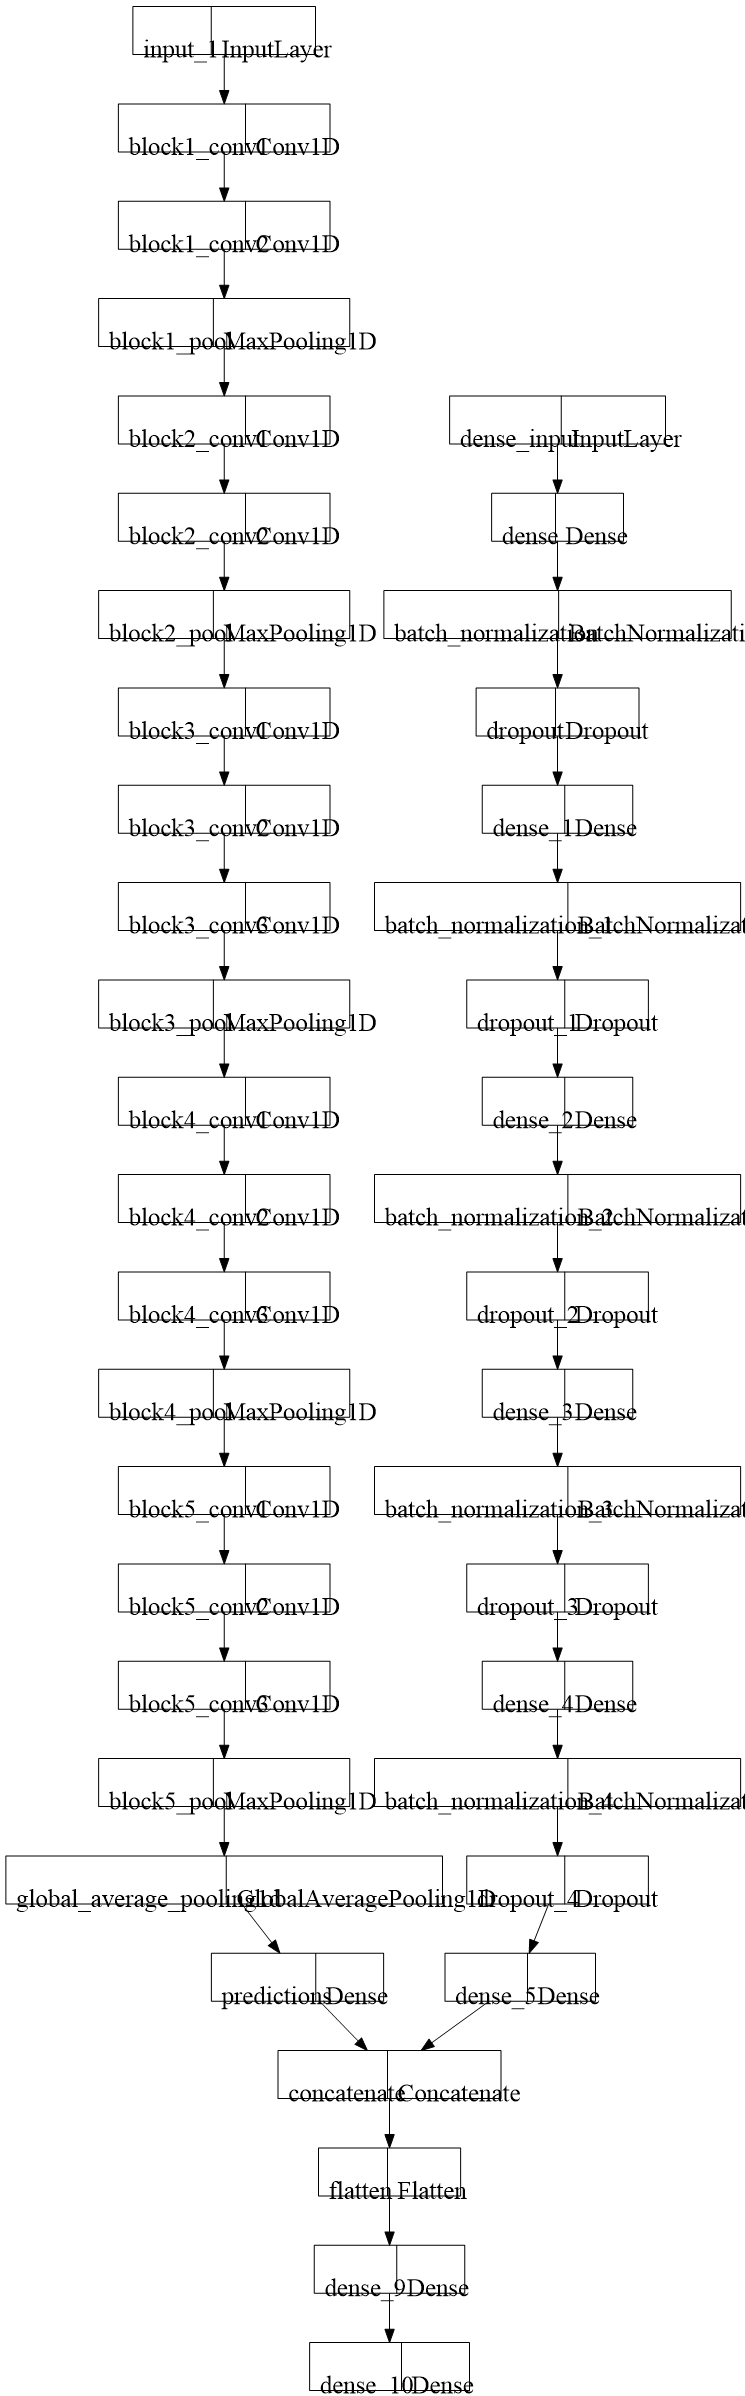

In [26]:
tf.keras.utils.plot_model(final_model)


In [29]:
final_model.fit([x_train, x_train], y_train.toarray(),validation_data=([x_test,x_test],y_test.toarray()))


32/32 [==============================] - 1s 40ms/step - loss: 0.4842 - accuracy: 0.8074 - f1_score: 0.8094 - val_loss: 0.5516 - val_accuracy: 0.7901 - val_f1_score: 0.8229


In [ ]:
base_mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               6880      
                                                                 
 batch_normalization (BatchN  (None, 160)              640       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 800)               128800    
                                                                 
 batch_normalization_1 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 800)               0

In [32]:
# Predict using the trained Early Fusion Classifier
predictions = final_model.predict([x_test,x_test])
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_list[data_order], predictions)
accuracy

11/11 [==============================] - 1s 32ms/step


0.7901234567901234